In [1]:

import numpy as np
import pandas as pd
import gc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K

print("Using Tensorflow {}".format(tf.__version__))
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("{} GPUs found".format(len(physical_devices)))
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Using {}".format(physical_devices[0]))

tf.random.set_seed(1234)

DEBUG = False

Using Tensorflow 2.1.0
1 GPUs found
Using PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
DEBUG = False


In [3]:

# Network hyperparameters from arXiv:1903.02433

# Training
BATCH_SIZE = 128
EPOCHS = 30 # 500000 in paper

# Optimizer
LEARNING_RATE = 1e-5
BETA_1 = 0.5
BETA_2 = 0.9

# Architecture
NOISE_DIM = 128

# Plotting
PREFIX = "img/{:.0f}D-{}batchsize-".format(NOISE_DIM, BATCH_SIZE)
DRAW_INTERVAL = 10

filenames = {
    "herwig": "Herwig_qcd_features.h5",
    "pythiabg": "GAN-data/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "GAN-data/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]

train_features = ["ptj1", "etaj1", "mj1", "ptj2", "etaj2", "phij2", "mj2"]
# condition_features = ["mjj"]


In [4]:
def load_data(datatype, stop = None, rotate = True, flip_eta = True):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = pd.DataFrame(dtype = "float32")

    for jet in ["j1", "j2"]:
        output_frame["pt" + jet] = np.sqrt(input_frame["px" + jet]**2 + input_frame["py" + jet]**2)
        output_frame["eta" + jet] = np.arcsinh(input_frame["pz" + jet] / output_frame["pt" + jet])
        output_frame["phi" + jet] = np.arctan2(input_frame["py" + jet], input_frame["px" + jet])
        output_frame["m" + jet] = input_frame["m" + jet]
        output_frame["p" + jet] = np.sqrt(input_frame["pz" + jet]**2 + output_frame["pt" + jet]**2)
        output_frame["e" + jet] = np.sqrt(output_frame["m" + jet]**2 + output_frame["p" + jet]**2)
        output_frame["tau21" + jet] = input_frame["tau2" + jet] / input_frame["tau1" + jet]
        output_frame["tau32" + jet] = input_frame["tau3" + jet] / input_frame["tau2" + jet]
    
    del input_frame
    gc.collect()

    # Not exact rotation, since negative angles for phi2 are flipped across the x-axis. Should be OK due to symmetry.
    if rotate:
        output_frame["phij2"] = np.abs(output_frame["phij2"] - output_frame["phij1"])
        output_frame["phij1"] = 0
    
    if flip_eta:
        flipped_frame = output_frame.copy()
        flipped_frame["etaj1"] *= -1
        flipped_frame["etaj2"] *= -1
        output_frame = output_frame.append(flipped_frame)
        del flipped_frame
        gc.collect()
    
    for jet in ["j1", "j2"]:
        output_frame["px" + jet] = output_frame["pt" + jet] * np.cos(output_frame["phi" + jet])
        output_frame["py" + jet] = output_frame["pt" + jet] * np.sin(output_frame["phi" + jet])
        output_frame["pz" + jet] = output_frame["pt" + jet] * np.sinh(output_frame["eta" + jet])
    
    # Dijet properties
    output_frame["pxjj"] = output_frame["pxj1"] + output_frame["pxj2"]
    output_frame["pyjj"] = output_frame["pyj1"] + output_frame["pyj2"]
    output_frame["pzjj"] = output_frame["pzj1"] + output_frame["pzj2"]
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt(output_frame["pxjj"]**2 + output_frame["pyjj"]**2 + output_frame["pzjj"]**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)

    # NaNs may arise from overly sparse jets with tau1 = 0, tau2 = 0, etc.
    output_frame.dropna(inplace = True)
    output_frame.reset_index(drop = True, inplace = True)
    
    return output_frame.astype('float32')


In [5]:
if DEBUG:
    df = load_data("herwig", stop = 10000)
else:
    df = load_data("herwig")


# Ensures all batches have same size

df.drop([i for i in range(df.shape[0] % (BATCH_SIZE * 4))], inplace = True)
df.reset_index(drop = True, inplace = True)

In [6]:
def cut_data(uncut_data, pTmin = 1200, etamax = 2.5):
    return uncut_data[np.logical_or(np.logical_and(uncut_data[:,0] > pTmin, np.abs(uncut_data[:,1]) < etamax), np.logical_and(uncut_data[:,3] > pTmin, np.abs(uncut_data[:,4]) < etamax))]

cut_df = cut_data(np.array(df[train_features]))

# Normalize all inputs between -1 and 1

scaler = MinMaxScaler((-1,1)).fit(cut_df)
feature_df = scaler.transform(cut_df)

X_train, X_test = train_test_split(feature_df, test_size = 0.25, random_state = 1234)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))

del df
gc.collect()


Dataset consists of 11717 batches of 128 samples each, total 1499776 samples
Testset consists of 3905 batches of 128 samples each, total 499840 samples


0

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(shape = (NOISE_DIM,)))
    model.add(layers.Dense(128, kernel_initializer = 'glorot_uniform'))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Reshape((8, 8, 2)))

    model.add(layers.Conv2DTranspose(32, kernel_size = 2, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(16, kernel_size = 3, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(len(train_features), activation = 'tanh'))

    return model

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.Input(shape = (len(train_features),)))
    model.add(layers.Dense(128))    
    model.add(layers.Reshape((8, 8, 2)))

    model.add(layers.Conv2D(64, kernel_size = 3, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))

    model.add(layers.Conv2D(32, kernel_size = 3, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))

    model.add(layers.Conv2D(16, kernel_size = 3, strides = 1, padding = "same"))
    model.add(layers.LeakyReLU(alpha = 0.2))

    model.add(layers.Flatten())
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model


In [10]:
generator = make_generator_model()
generator.summary()
discriminator = make_discriminator_model()
discriminator.summary()
mse = tf.keras.losses.MeanSquaredError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 2)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 32)          288       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 32)          1

In [11]:
@tf.function
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
@tf.function
def generator_loss(fake_output):
    return mse(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)

In [14]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [15]:
@tf.function
def train_step_generator():
  gen_input = tf.random.uniform([BATCH_SIZE, NOISE_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_vector = generator(gen_input, training=True)
    fake_output = discriminator(generated_vector, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [16]:
@tf.function
def train_step_discriminator(vectors):
  gen_input = tf.random.uniform([BATCH_SIZE, NOISE_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_vector = generator(gen_input, training=True)

    real_output = discriminator(vectors, training=True)
    fake_output = discriminator(generated_vector, training=True)
    
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [17]:
@tf.function
def evaluate_generator():
  gen_input = tf.random.uniform([BATCH_SIZE, NOISE_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_vector = generator(gen_input, training=False)
    fake_output = discriminator(generated_vector, training=False)
    gen_loss = generator_loss(fake_output)
  
  return gen_loss

In [18]:
@tf.function
def evaluate_discriminator(vectors):
  gen_input = tf.random.uniform([BATCH_SIZE, NOISE_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_vector = generator(gen_input, training=False)

    real_output = discriminator(vectors, training=False)
    fake_output = discriminator(generated_vector, training=False)
    
    disc_loss = discriminator_loss(real_output, fake_output)
  
  return disc_loss

In [19]:
def graph_gan(generator, epoch):
    plt.close()

    realdata = scaler.inverse_transform(X_train)
    fakedata_uncut = scaler.inverse_transform(generator(tf.random.uniform((20000, NOISE_DIM)), training=False))

    # At least one jet has pT > 1200 and |eta| < 2.5
    fakedata = cut_data(fakedata_uncut)
    
    f, a = plt.subplots(2, 2, constrained_layout=True)

    f.suptitle("GAN Generation")
    label = "Herwig Background"

    a[0, 0].set_title("Leading Jet Mass")
    a[0, 0].set_ylabel("Normalized to Unity")
    a[0, 0].set_xlabel("$m_{J_1}$")
    a[0, 0].hist(realdata[:,2], bins = 25, range = (0, 600), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[0, 0].hist(fakedata[:,2], bins = 25, range = (0, 600), color = "tab:blue", histtype = "step", label = "GAN", density = True)

    a[0, 1].set_title("Subleading Jet Mass")
    a[0, 1].set_ylabel("Normalized to Unity")
    a[0, 1].set_xlabel("$m_{J_2}$")
    a[0, 1].hist(realdata[:,6], bins = 25, range = (0, 600), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[0, 1].hist(fakedata[:,6], bins = 25, range = (0, 600), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    a[0, 1].legend(loc="upper right")
    
    p_real = np.sqrt((realdata[:,0]+realdata[:,3]*np.cos(realdata[:,5]))**2 + (realdata[:,3]*np.sin(realdata[:,5]))**2 + (realdata[:,0]*np.sinh(realdata[:,1])+realdata[:,3]*np.sinh(realdata[:,4]))**2)
    e_real = np.sqrt((realdata[:,0]*np.cosh(realdata[:,1]))**2+realdata[:,2]**2) + np.sqrt((realdata[:,3]*np.cosh(realdata[:,4]))**2+realdata[:,6]**2)
    m_real = np.sqrt(e_real**2-p_real**2)
    
    p_fake = np.sqrt((fakedata[:,0]+fakedata[:,3]*np.cos(fakedata[:,5]))**2 + (fakedata[:,3]*np.sin(fakedata[:,5]))**2 + (fakedata[:,0]*np.sinh(fakedata[:,1])+fakedata[:,3]*np.sinh(fakedata[:,4]))**2)
    e_fake = np.sqrt((fakedata[:,0]*np.cosh(fakedata[:,1]))**2+fakedata[:,2]**2) + np.sqrt((fakedata[:,3]*np.cosh(fakedata[:,4]))**2+fakedata[:,6]**2)
    m_fake = np.sqrt(e_fake**2-p_fake**2)

    a[1, 0].set_title("Dijet Mass")
    a[1, 0].set_ylabel("Normalized to Unity")
    a[1, 0].set_xlabel("$m_{JJ}$")
    a[1, 0].hist(m_real, bins = 25, range = (2000, 6000), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[1, 0].hist(m_fake, bins = 25, range = (2000, 6000), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    
    a[1, 1].set_title("Dijet Energy")
    a[1, 1].set_ylabel("Normalized to Unity")
    a[1, 1].set_xlabel("$E_{JJ}$")
    a[1, 1].hist(e_real, bins = 25, range = (2000, 6000), color = "tab:orange", alpha = 0.5, label = label, density = True)
    a[1, 1].hist(e_fake, bins = 25, range = (2000, 6000), color = "tab:blue", histtype = "step", label = "GAN", density = True)

    if DEBUG:
        plt.show()
    else:
         plt.show()



In [20]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [24]:
def graph_losses(epoch):
    plt.close()

    f, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)

    f.suptitle("Loss Functions")

    ax1.set_title("Generator Loss")
    ax1.set_ylabel("Mean-Square Error")
    ax1.set_xlabel("Epoch")
    ax1.plot(train_gen_losses, 'b', label = "Training loss")
    ax1.plot(test_gen_losses, 'r', label = "Validation loss")
    ax1.legend(loc="upper right")

    ax2.set_title("Discriminator Loss")
    ax2.set_ylabel("Binary Cross-Entropy")
    ax2.set_xlabel("Epoch")
    ax2.plot(train_disc_losses, 'b', label = "Training loss")
    ax2.plot(test_disc_losses, 'r', label = "Validation loss")

    if DEBUG:
        plt.show()
    else:
        plt.show()

In [25]:
def train(dataset, testset, epochs):
    for epoch in tqdm(range(epochs)):
        print_losses = False #((epoch + 1) % 10 == 0)

        draw_outputs = True
       # ((epoch + 1) % DRAW_INTERVAL == 0)

        train_gen_loss = 0
        train_disc_loss = 0

        test_gen_loss = 0
        test_disc_loss = 0

        # Training

        for batchnum, image_batch in enumerate(dataset):
            train_disc_loss += K_eval(train_step_discriminator(image_batch)) / len_dataset
            train_gen_loss += K_eval(train_step_generator()) / len_dataset


        train_gen_losses.append(train_gen_loss)
        train_disc_losses.append(train_disc_loss)

        # Evaluation

        for batchnum, test_batch in enumerate(testset):
            test_gen_loss += K_eval(evaluate_generator()) / len_testset
            test_disc_loss += K_eval(evaluate_discriminator(test_batch)) / len_testset

        test_gen_losses.append(test_gen_loss)
        test_disc_losses.append(test_disc_loss)

        # Logging

        if print_losses:
            print()
            print("Epoch " + str(epoch + 1) + ":")
            print()
            print("Generator training loss: " + str(train_gen_losses[-1]))
            print("Discriminator training loss: " + str(train_disc_losses[-1]))
            print()
            print("Generator validation loss: " + str(test_gen_losses[-1]))
            print("Discriminator validation loss: " + str(test_disc_losses[-1]))

        if draw_outputs:
            print()
            print("Epoch " + str(epoch + 1) + ":")
            graph_gan(generator, epoch + 1)
            graph_losses(epoch + 1)


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]


Epoch 1:


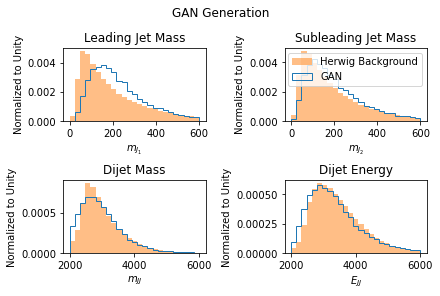

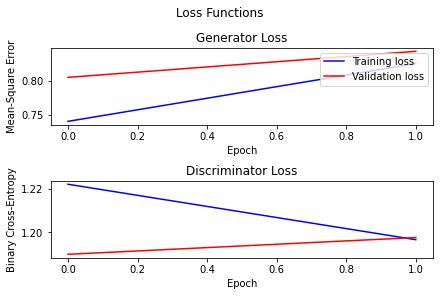

  3%|██▊                                                                                | 1/30 [01:26<41:40, 86.24s/it]


Epoch 2:


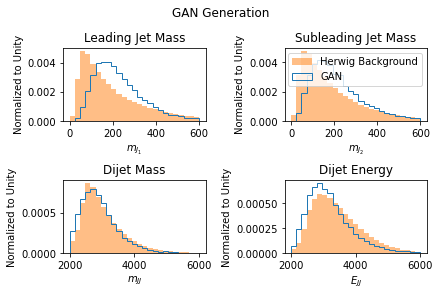

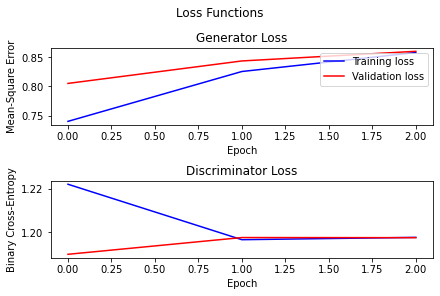

  7%|█████▌                                                                             | 2/30 [02:52<40:12, 86.15s/it]


Epoch 3:


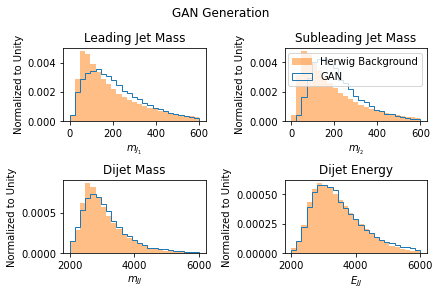

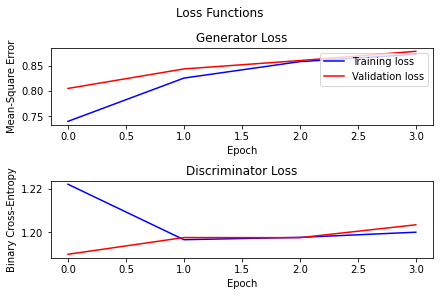

 10%|████████▎                                                                          | 3/30 [04:17<38:39, 85.90s/it]


Epoch 4:


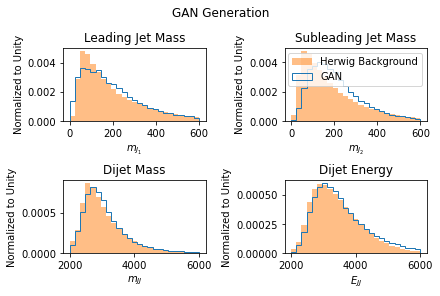

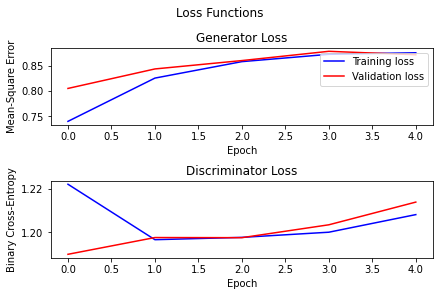

 13%|███████████                                                                        | 4/30 [05:42<37:03, 85.51s/it]


Epoch 5:


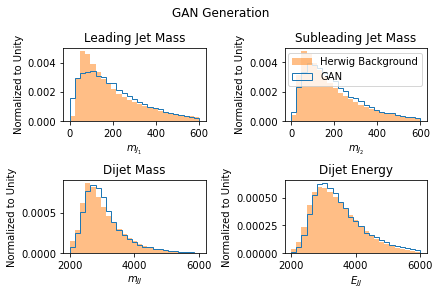

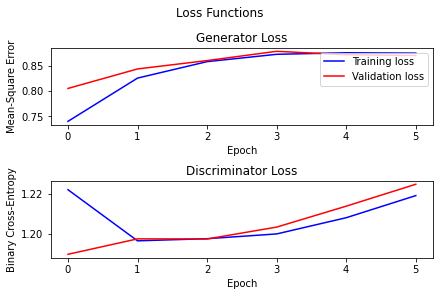

 17%|█████████████▊                                                                     | 5/30 [07:07<35:37, 85.51s/it]


Epoch 6:


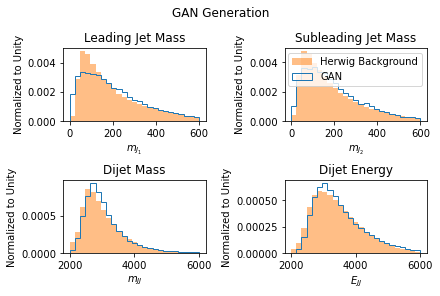

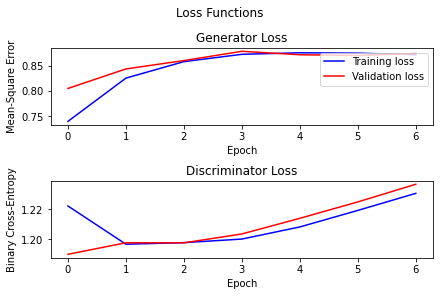

 20%|████████████████▌                                                                  | 6/30 [08:32<34:06, 85.25s/it]


Epoch 7:


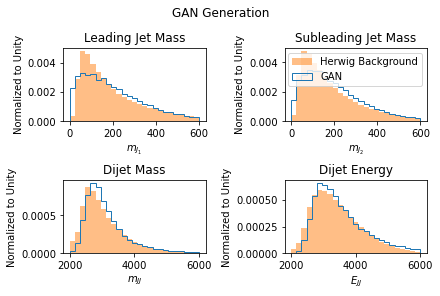

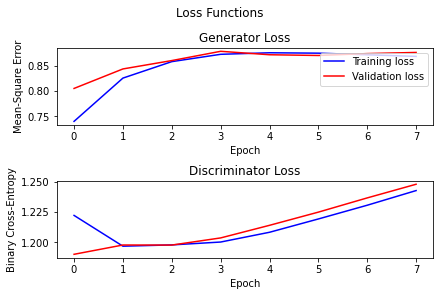

 23%|███████████████████▎                                                               | 7/30 [09:58<32:49, 85.62s/it]


Epoch 8:


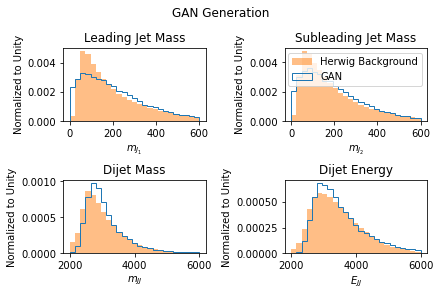

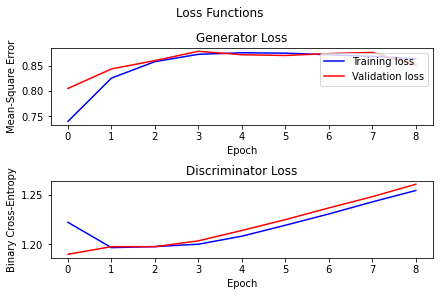

 27%|██████████████████████▏                                                            | 8/30 [11:27<31:43, 86.54s/it]


Epoch 9:


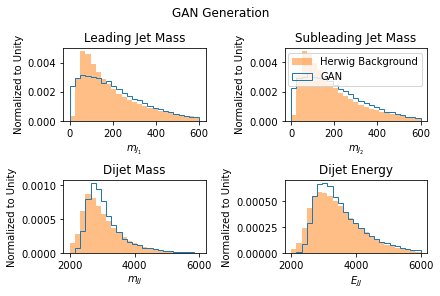

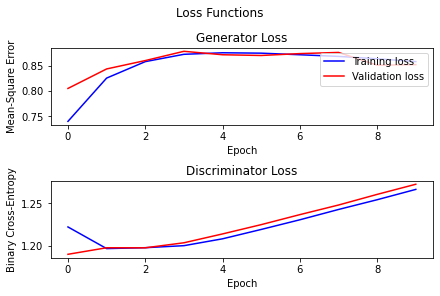

 30%|████████████████████████▉                                                          | 9/30 [13:08<31:46, 90.80s/it]


Epoch 10:


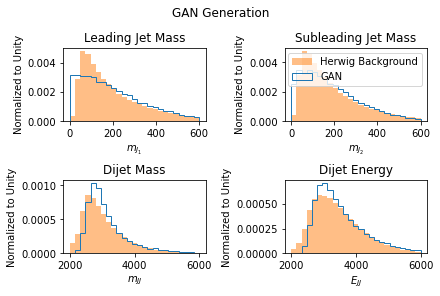

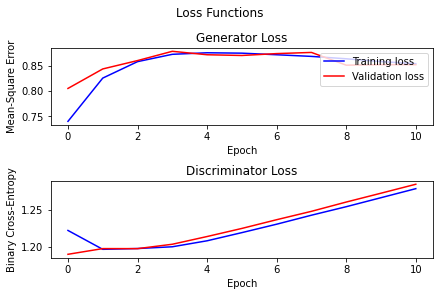

 33%|███████████████████████████▎                                                      | 10/30 [14:42<30:34, 91.75s/it]


Epoch 11:


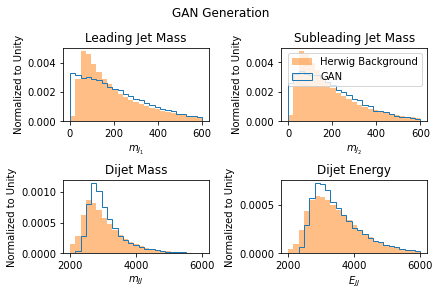

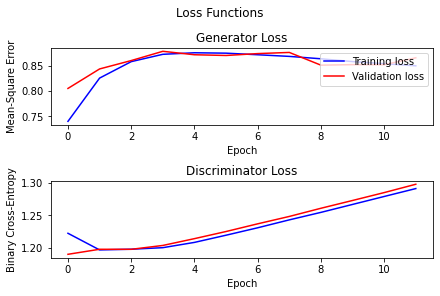

 37%|██████████████████████████████                                                    | 11/30 [16:14<29:05, 91.87s/it]


Epoch 12:


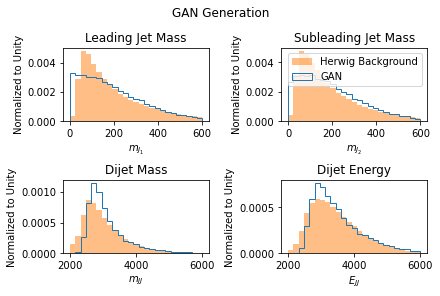

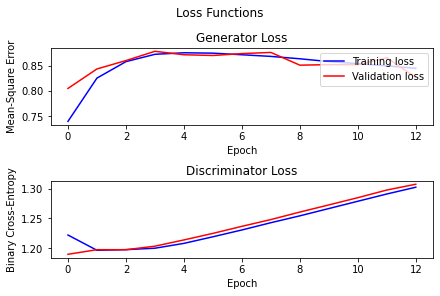

 40%|████████████████████████████████▊                                                 | 12/30 [17:47<27:39, 92.21s/it]


Epoch 13:


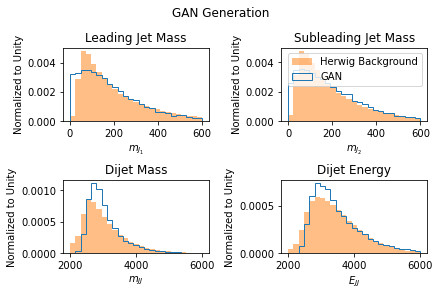

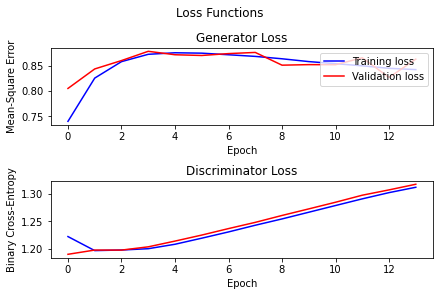

 43%|███████████████████████████████████▌                                              | 13/30 [19:20<26:10, 92.38s/it]


Epoch 14:


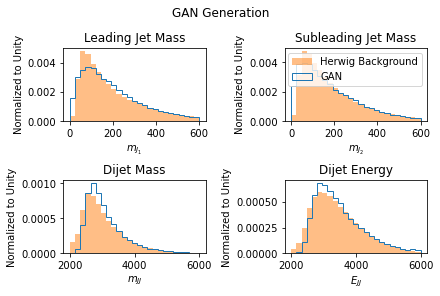

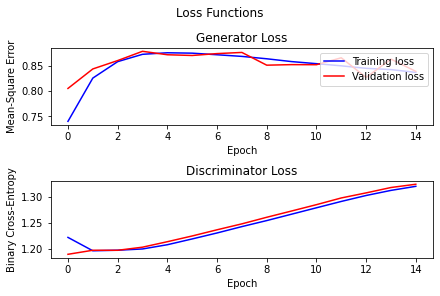

 47%|██████████████████████████████████████▎                                           | 14/30 [20:52<24:38, 92.38s/it]


Epoch 15:


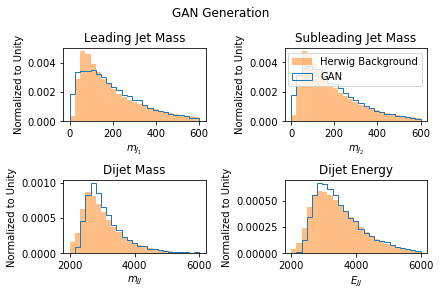

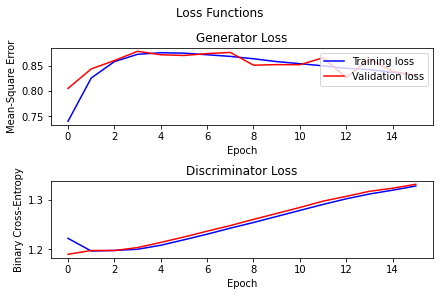

 50%|█████████████████████████████████████████                                         | 15/30 [22:24<23:05, 92.36s/it]


Epoch 16:


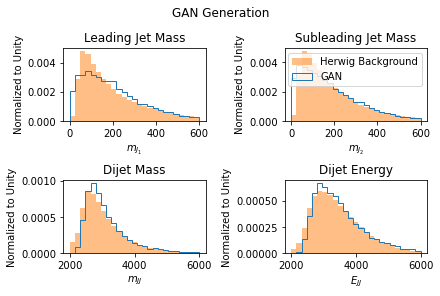

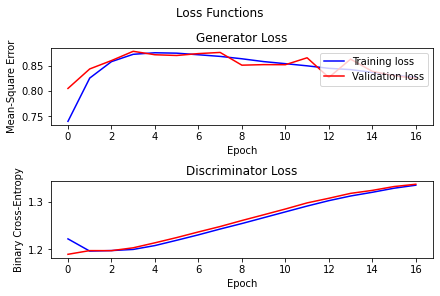

 53%|███████████████████████████████████████████▋                                      | 16/30 [23:57<21:32, 92.36s/it]


Epoch 17:


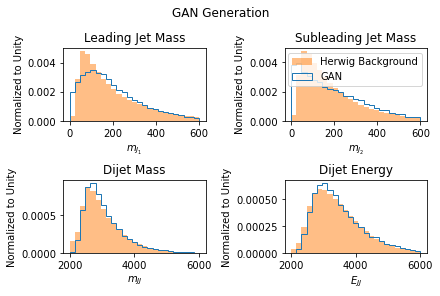

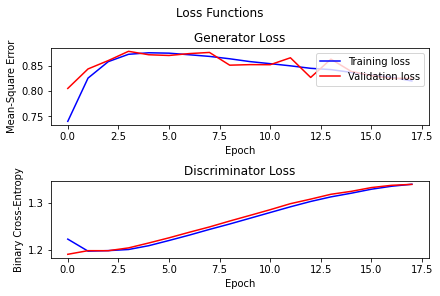

 57%|██████████████████████████████████████████████▍                                   | 17/30 [25:29<20:00, 92.38s/it]


Epoch 18:


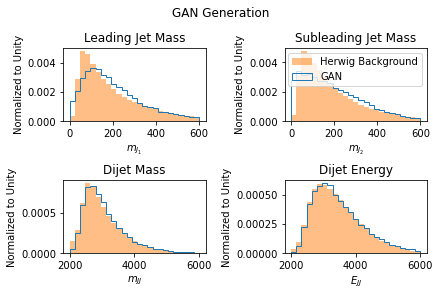

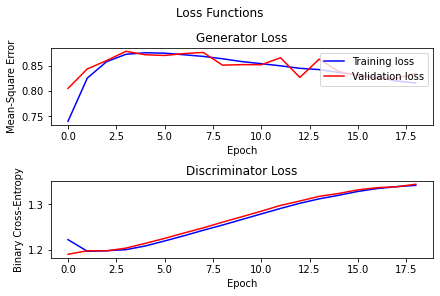

 60%|█████████████████████████████████████████████████▏                                | 18/30 [27:01<18:28, 92.35s/it]


Epoch 19:


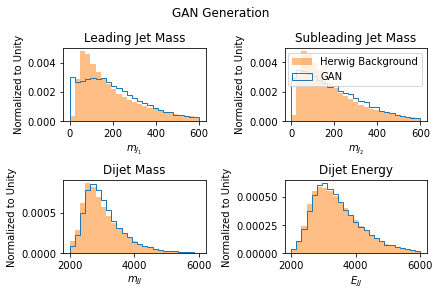

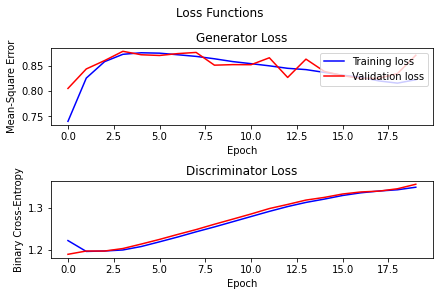

 63%|███████████████████████████████████████████████████▉                              | 19/30 [28:34<16:56, 92.37s/it]


Epoch 20:


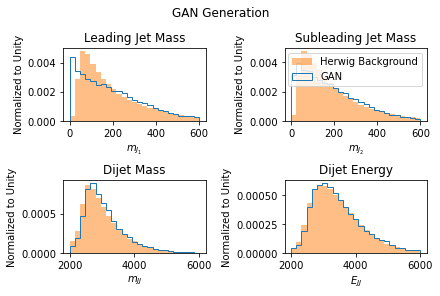

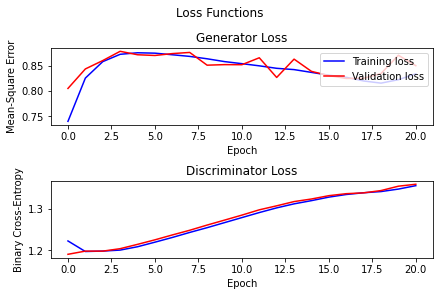

 67%|██████████████████████████████████████████████████████▋                           | 20/30 [30:06<15:24, 92.41s/it]


Epoch 21:


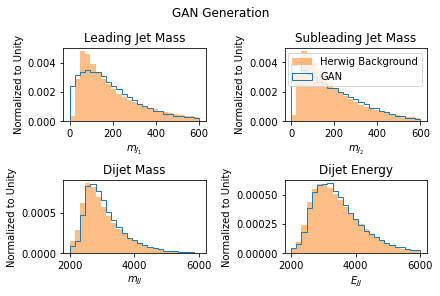

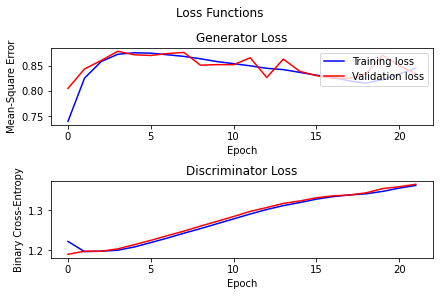

 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [31:39<13:51, 92.40s/it]


Epoch 22:


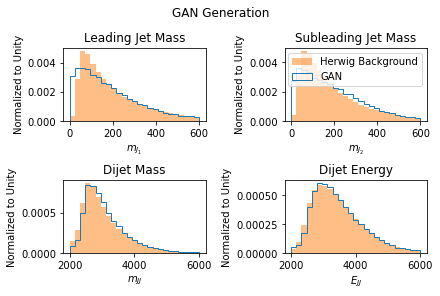

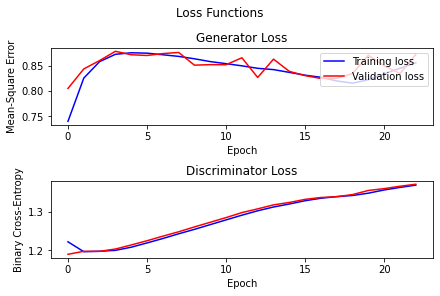

 73%|████████████████████████████████████████████████████████████▏                     | 22/30 [33:11<12:18, 92.34s/it]


Epoch 23:


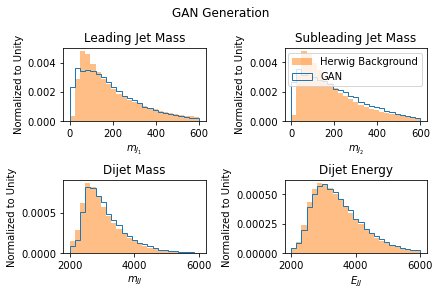

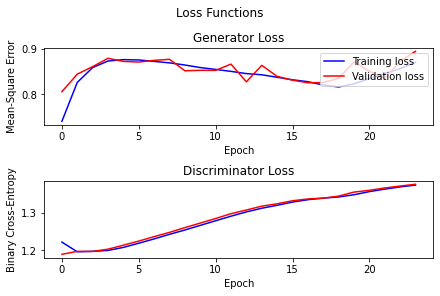

 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [34:43<10:46, 92.40s/it]


Epoch 24:


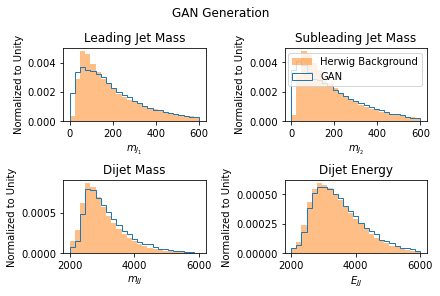

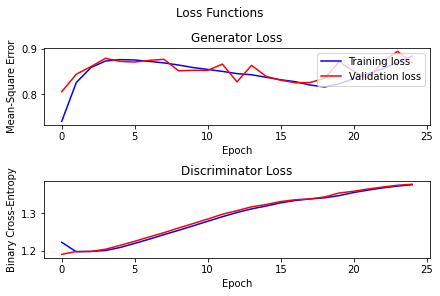

 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [36:16<09:14, 92.40s/it]


Epoch 25:


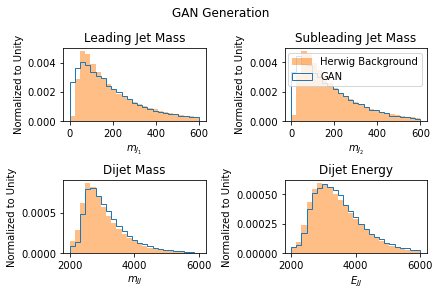

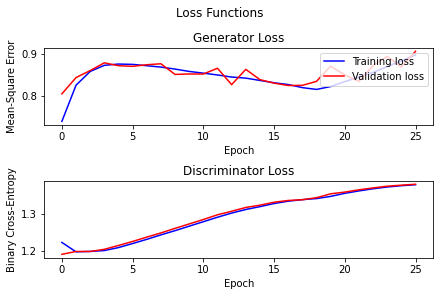

 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [37:49<07:42, 92.54s/it]


Epoch 26:


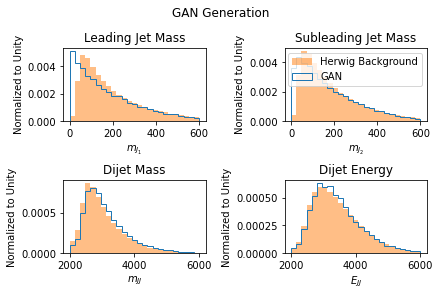

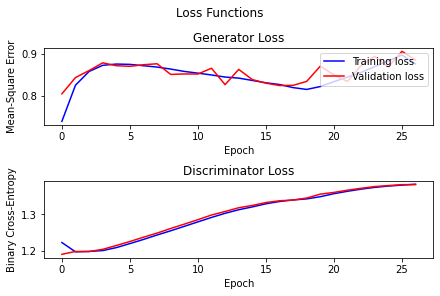

 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [39:22<06:11, 92.79s/it]


Epoch 27:


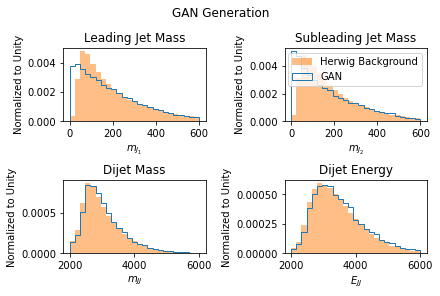

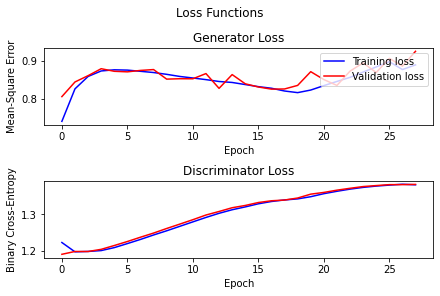

 90%|█████████████████████████████████████████████████████████████████████████▊        | 27/30 [40:55<04:38, 92.97s/it]


Epoch 28:


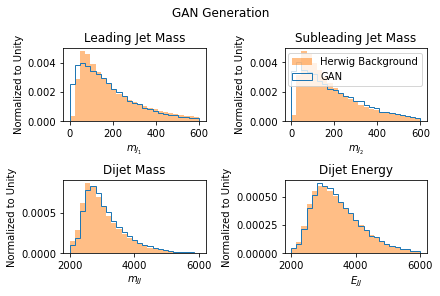

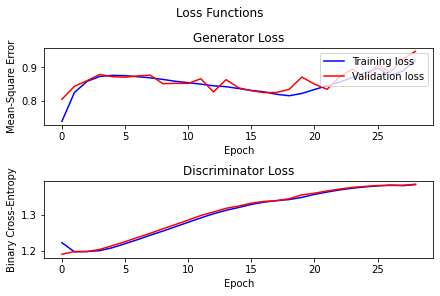

 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [42:28<03:05, 92.80s/it]


Epoch 29:


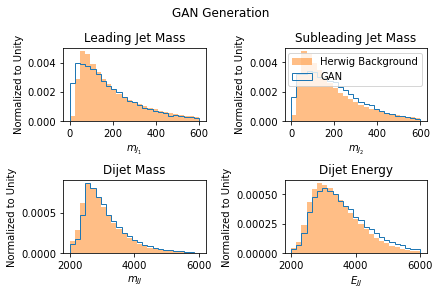

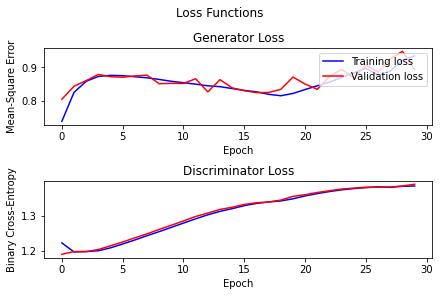

 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [44:00<01:32, 92.64s/it]


Epoch 30:


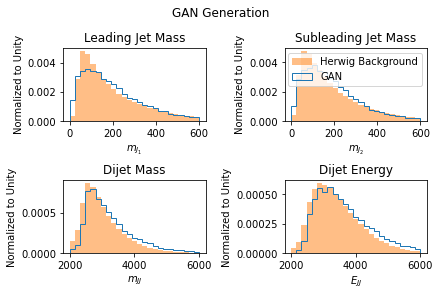

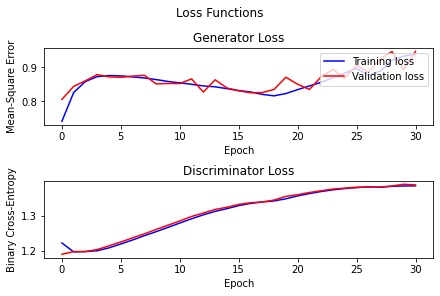

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [45:32<00:00, 91.09s/it]


In [26]:
train(train_dataset, test_dataset, EPOCHS)